<a href="https://colab.research.google.com/github/Juanba98/StableDiffusion/blob/main/StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1_kbRZPTjnFgViPrmGcUsaszEdYa8XTpq?usp=sharing#scrollTo=Mb-u1yDAJ23R

# **Library installation**

In [28]:
'''
Diffusers provides pretrained diffusion models across multiple modalities, 
such as vision and audio, and serves as a modular toolbox for inference and training of diffusion models.
'''
print("Downloading Diffusers...")
!pip install diffusers==0.2.4 &> /dev/null
#Transformers to encode the text
print("Downloading transformers, scipy, ftfy ...")
!pip install transformers scipy ftfy &> /dev/null

#print("Downloading transformers, scipy, ftfy ...")
#!pip install "ipywidgets>=7, <8" &> /dev/null
print("Installation finished.")

Installation finished.


#**Loading libraries**

In [29]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

# Custom Pipeline

##Utils

In [30]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))
  
def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

In [31]:
class Pipeline (object):

  def __init__(self):

    # 1. Load the autoencoder model which will be used to decode the latents into image space. 
    vae = AutoencoderKL.from_pretrained(
      'CompVis/stable-diffusion-v1-4', 
      subfolder='vae', 
      use_auth_token=True)
    
    self.vae = vae.to(device)

    # 2. Load the tokenizer and text encoder to tokenize and encode the text. 
    self.tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
    text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
    self.text_encoder = text_encoder.to(device)

    # 3. The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained(
      'CompVis/stable-diffusion-v1-4', 
      subfolder='unet', 
      use_auth_token=True)
    
    self.unet = unet.to(device)

    # 4. Create a scheduler for inference
    self.scheduler = LMSDiscreteScheduler(
      beta_start=0.00085, 
      beta_end=0.012,
      beta_schedule='scaled_linear', 
      num_train_timesteps=1000)
    

  def __call__ (self,prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                batch_size=2 ):
    
    if isinstance(prompts, str):
      prompts = [prompts]

    # Prompts -> text embeds
    text_embeds = self.get_text_embeds(prompts)

    # Text embeds -> img latents
    latents = self.produce_latents(
        text_embeds, height=height, width=width, latents=latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
        return_all_latents=return_all_latents)

    # Img latents -> imgs
    if return_all_latents:

      all_imgs = []

      for i in tqdm(range(0, len(latents), batch_size)):
        imgs = self.decode_img_latents(latents[i:i+batch_size])
        all_imgs.extend(imgs)
      
      return all_imgs
    
    imgs = self.decode_img_latents(latents)

    return imgs

  def get_text_embeds(self,prompt):
    # Tokenize text and get embeddings
    text_input = self.tokenizer(
      prompt, 
      padding='max_length', 
      max_length=self.tokenizer.model_max_length,
      truncation=True, 
      return_tensors='pt')
    
    with torch.no_grad():
      text_embeddings = self.text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = self.tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=self.tokenizer.model_max_length, 
      return_tensors='pt')
    
    with torch.no_grad():
      uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings


  def produce_latents(self, text_embeddings, height=512, width=512,
                      num_inference_steps=50, guidance_scale=7.5, latents=None,
                      return_all_latents=False):
    
    if latents is None:
      latents = torch.randn(
          (
              text_embeddings.shape[0] // 2, 
              self.unet.in_channels,
              height // 8, 
              width // 8
          )
        )
      
    latents = latents.to(device)

    self.scheduler.set_timesteps(num_inference_steps)
    latents = latents * self.scheduler.sigmas[0]

    latent_list = [latents]

    with autocast('cuda'):
      for i, t in tqdm(enumerate(self.scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = self.scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = self.unet(
              latent_model_input, 
              t, 
              encoder_hidden_states=text_embeddings)['sample']

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = self.scheduler.step(noise_pred, i, latents)['prev_sample']
        latent_list.append(latents)
    
    if not return_all_latents:
      return latents


    all_latents = torch.cat(latent_list, dim=0)
    return all_latents

  def decode_img_latents(self,latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
      imgs = self.vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]

    return pil_images

## **Run**

In [ ]:
pipeline = Pipeline() 

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

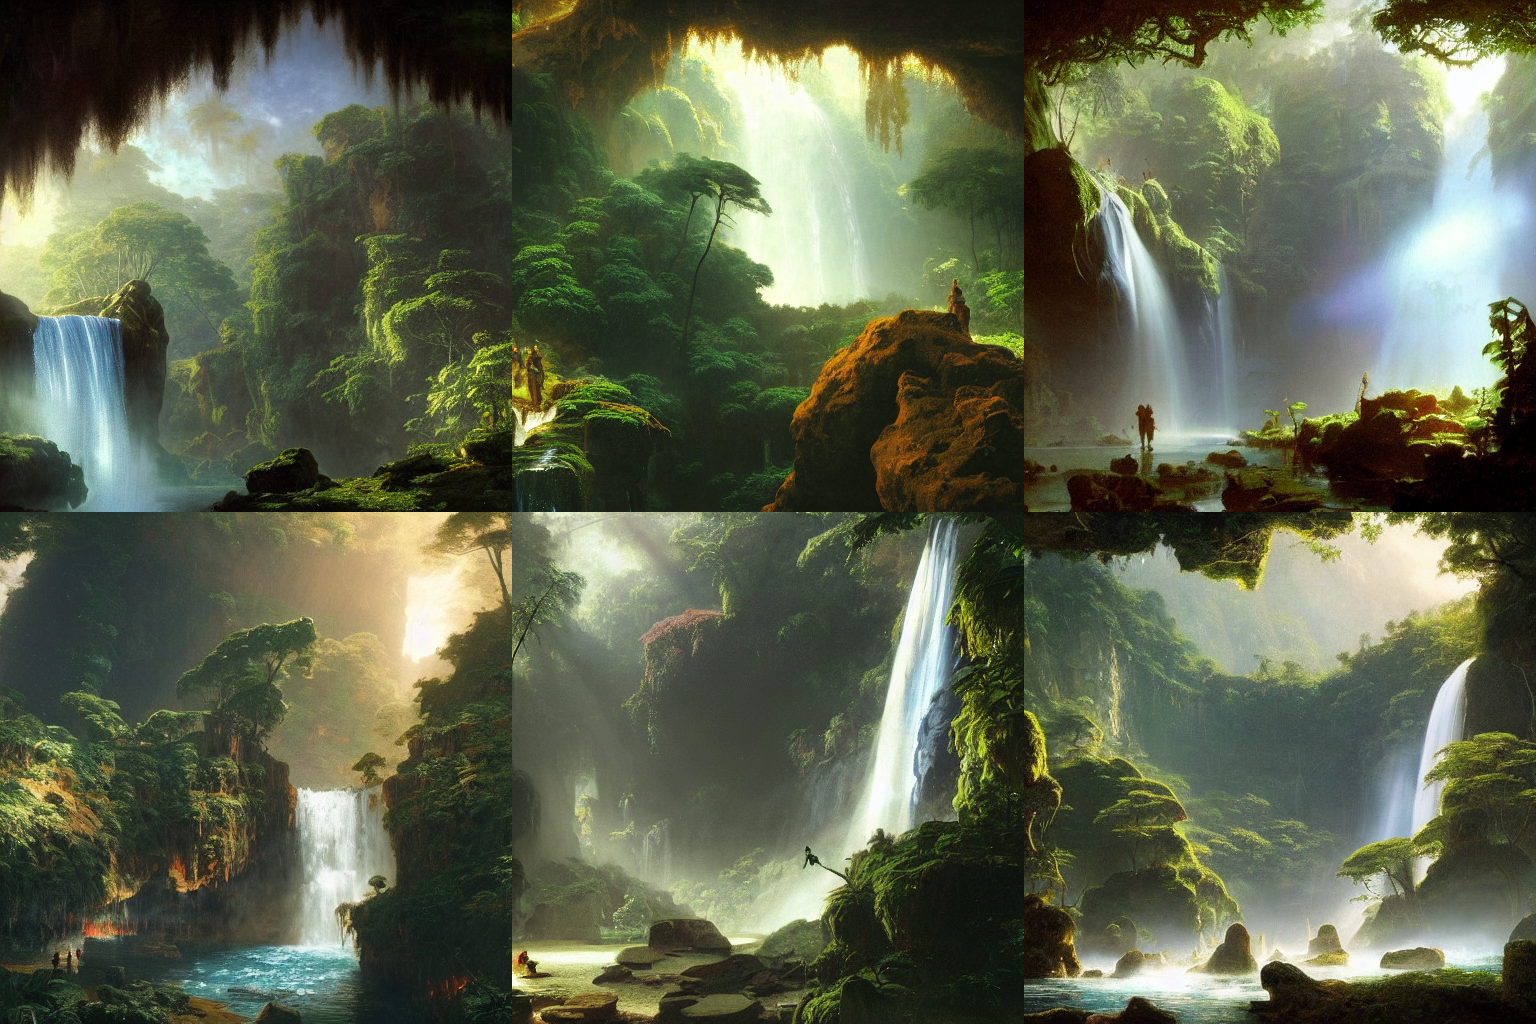

In [103]:
#@title **Image Generation**
prompt = "A humongous cave opening in a rainforest, waterfall in the middle, concept art, by Albert Bierstadt and Sylvain Sarrailh, sense of scale, ultra realisitc, cinematic, atmospheric, composition, artstaion HQ" #@param {type:"string"}
height = 512 #@param {type:"integer"}
width = 512 #@param {type:"integer"}
num_inference_steps = 50 #@param {type:"integer"}
num_images = 6 #@param {type:"integer"}
num_rows = 2 #@param {type:"integer"}
num_cols = 3 #@param {type:"integer"}
images = []
for i in range(0,num_images):
  image = pipeline(prompt, height, width, num_inference_steps)[0]
  images.append(image)


grid = image_grid(images, rows=num_rows, cols=num_cols)
grid


##Video

In [ ]:
prompt = 'A samurai in epic sakura tree orchid surrounded by mountains and a lake, highly detailed, digital painting, concept art, smooth, sharp focus, illustration, art by greg rutkowski'
video_frames = pipeline(
    prompt, num_inference_steps=50, return_all_latents=True)

vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name,10)
display_video(vid_name)

0it [00:00, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]